In [1]:
import subprocess
from multiprocessing import Pool,cpu_count
import os
from itertools import product,repeat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import spline
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
#import statsmodels.api as smdl
%run averaging.ipynb
%run optimize_slope.ipynb

ncores=cpu_count()

In [2]:
area_er = 2*(3.9+0.1+0.1*0.1+3.9*0.1)
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

In [3]:
def write_mdl(file_name,outfolder,iterations,ic,sf,sm,kleak,ldf,serca_frac,write=True):
    ftext = """sprintf(my_seed,"%05g",SEED)

    iterations = e3

    INCLUDE_FILE = "../outputLoc.mdl"
    INCLUDE_FILE = "../initialization.mdl"
    INCLUDE_FILE = "parameters.mdl"
    /* Modifications in Parameters */
        VDCC_number_presynaptic = 40

        n_Glu_neuron =  1 //2000
        GluT_density_astrocyte = 0.1 //1000

        ca_conc_presynaptic_er = e-6     //initial ER conc specified here!!!!!
        //ryr_number_presynaptic = 0 //no RYR

    f =                                 //SERCA parameter adjustments here!!!!!!!!!!

    sm = //multiply 4 serca parameters (across sides)

    /*Initial SERCA fractions*/
    serca_x1_feq = 
    serca_x1a_feq = 
    serca_x2_feq = 
    serca_y1_feq = 
    serca_y1a_feq = 
    serca_y2_feq = 

    INCLUDE_FILE = "rxn_rate_constants.mdl"
    /* Modifications in Reaction Rate Constants */

    k_ER_leak = 
    ldf = 
    ER_leak_density_presynaptic = ldf*ER_leak_density_presynaptic

    /* Output Folder */
            //isi = "40"
        sprintf(VDCC, "%g", VDCC_number_presynaptic)
        sprintf(f_mult, "%g", f) 
        sprintf(s_mult, "%g", sm)
        sprintf(kleak, "%g", k_ER_leak)
        sprintf(LDF, "%g", ldf)
        sprintf(init_er_conc, "%g", ca_conc_presynaptic_er*1e6)   	
        fname = 

        //output_folder = outputLoc & "ppf/" & fname & "/ldf" & LDF & "/sm" & s_mult & "/" & f_mult & "/" & init_er_conc & "/kleak" & kleak & "/s_" & my_seed
        //output_folder = outputLoc & "ppf/" & fname & "/ldf" & LDF & "/" & "/kleak" & kleak & "/s_" & my_seed
        output_folder = outputLoc & "ppf/" & fname & "/s_" & my_seed
        
    /* Rates for P/Q-type Voltage Dependent Calcium Channels */
    /* From Bischoffberger et al., 2005, , Biophys. J.*/

        k_VDCC_PQ_C01 = 0
        k_VDCC_PQ_C12 = 0
        k_VDCC_PQ_C23 = 0
        k_VDCC_PQ_C34 = 0
        k_VDCC_PQ_C43 = 0
        k_VDCC_PQ_C32 = 0
        k_VDCC_PQ_C21= 0
        k_VDCC_PQ_C10 = 0
        k_VDCC_PQ_Ca = 0

    INCLUDE_FILE = "triggered_release.inc.mdl"

    INCLUDE_FILE = "rxn_outputRS.mdl"
    //INCLUDE_FILE = "viz_output.mdl"
    """
    ftext=ftext.replace('k_ER_leak = ', 'k_ER_leak = '+str(kleak))
    ftext=ftext.replace('ldf = ', 'ldf = '+str(ldf))
    ftext=ftext.replace('iterations = ', 'iterations = '+str(iterations))
    ftext=ftext.replace('sm = ', 'sm = '+str(sm))
    ftext=ftext.replace('ca_conc_presynaptic_er = ', 'ca_conc_presynaptic_er = '+str(ic))
    ftext=ftext.replace(' f = ',' f = '+str(sf))
    ftext=ftext.replace('fname = ','fname = '+'"'+str(outfolder)+'"')
    for i,p in enumerate(['x1','x1a','x2','y2','y1a','y1']):
        old="serca_"+p+"_feq = "
        new="serca_"+p+"_feq = "+str(serca_frac[i])
        ftext=ftext.replace(old,new)
    if write:
        with open(file_name,'w') as wfile:
            wfile.write(ftext)

      

In [13]:
#Generate mdls for checking equilibrium at 250 for normal, sm + kleak to verify relation between the two

%run get_SERCA_equilibrium.ipynb

final_conc=500
sf=2
initial_conc=[250]
serca_mult=np.arange(30,300,30)
A=1468.2314410480349
B=-2448.0436681222704
k_leaks=[int(round(k_leak)) for k_leak in A*np.log(serca_mult)+B]
print("k_leaks: ",k_leaks)
seed_num=40

folder="/home/kabir/Project/tripartiteSynapse/brute500_9/"
outfolder="brute12"

iterations=1500

k_leaks:  [2546, 3563, 4159, 4581, 4909, 5176, 5403, 5599, 5772]


In [50]:
#Generate mdls for checking leak flux as a function of leak density.

%run get_SERCA_equilibrium.ipynb

final_conc=500
sf=2
initial_conc=[250]
serca_mult=[0]
k_leaks=[2546,577]
leak_density_factor=[0.2,0.4,0.6,0.8,1]
seed_num=10

folder="/home/kabir/Project/tripartiteSynapse/brute500_9/"
outfolder="ldf"

iterations=1500

In [93]:
#Generate mdls for checking equilibrium at 250 for normal, sm + kleak. Updated ldf to 1.

%run get_SERCA_equilibrium.ipynb

final_conc=500
sf=2
initial_conc=[250]
serca_mult=np.arange(30,300,30)
A=146.82314410480349
B=-244.80436681222704
k_leaks=[int(round(k_leak)) for k_leak in A*np.log(serca_mult)+B]
leak_density_factor=[1]
print("k_leaks: ",k_leaks)
seed_num=40

folder="/home/kabir/Project/tripartiteSynapse/brute500_10/"
outfolder="brute12"

iterations=1500

k_leaks:  [255, 356, 416, 458, 491, 518, 540, 560, 577]


In [34]:
#Generate mdls for checking equilibrium at 250 for normal, sm + kleak. Updated ldf to 1.
#ODE estimates sm=3.53087274 and k_leak=35.05599586580223


%run get_SERCA_equilibrium.ipynb

final_conc=500
sf=2
initial_conc=[250]
serca_mult=[3.53087274]
k_leaks=[35.0559]
leak_density_factor=[1]
serca_frac=[0.6365812286479662, 0.30426373530338957, 0.036326316771787354, 0.004830677161924464, 0.011330644704584886, 0.006667397493355757]
#print("k_leaks: ",k_leaks)
seed_num=50

folder="/home/kabir/Project/tripartiteSynapse/final500/"
outfolder="final500"

iterations=1500

In [38]:
#Generate mdls for checking equilibrium at 250 for normal, sm + kleak. Updated ldf to 1.
#ODE estimates sm=1.57496328 and k_leak=35.05599586580223


%run get_SERCA_equilibrium.ipynb

final_conc=750
sf=3
initial_conc=[250]
serca_mult=[1.57496328]
k_leaks=[35.0559]
leak_density_factor=[1]
#print("k_leaks: ",k_leaks)
seed_num=50
serca_frac=[0.5193872319795779, 0.3723915862041316, 0.06672380727358877, 0.008685734913775726, 0.02058740798496984, 0.012224231669021056]
folder="/home/kabir/Project/tripartiteSynapse/final/"
outfolder="final750"

iterations=1500

In [65]:
fnames=[]

for (ic,sm,k_leak,ldf) in product(initial_conc,serca_mult,k_leaks,leak_density_factor):
    file_name=folder+"pred_final750_eq.mdl"#"norm_sm"+str(sm)+"ldf"+str(ldf)+"kl"+str(k_leak)+".mdl"#+str(sm)+"i"+str(ic)+"f"+str(sf)+"l"+str(k_leak)+".mdl"
    fnames.append(file_name)
    write_mdl(file_name,outfolder,iterations,ic,sf,sm,k_leak,ldf,serca_frac,write=True)
        

In [66]:
#write run.sh
with open(folder+'run.sh','w') as f:
    for name in fnames:
            f.write("sed --i 's/^#PBS -J.*/#PBS -J 1-"+str(seed_num)+"/' pbs.py\n")
            f.write("qsub -N "+name.replace('.mdl','').replace(folder,'')+" -v I='"+name.replace('/kabir/Project/','/subhadra/kabir/')+"' pbs.py\n")
            f.write("\n")

In [60]:
len(fnames)

1

In [67]:
#sync script files to cluster
p=subprocess.call(["rsync","-arhP",folder[:-1],"subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/"])

In [12]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/"+outfolder,"/data/kabir/output/ppf/"])

# ER Ca plot

In [27]:
%run averaging1.ipynb
#checking refilling times for 500 sf=2
data_locs=[]
#data_type=['pmca&leak_ca_flux.dat']
data_type=['ca.dat']#,'pmca&leak_ca_flux.dat']
columns=[[3]]#,[3]]#,[3]]
data_type
data_locs=["/data/kabir/output/ppf/"+outfolder]

p=Pool(ncores-1)
g=[(a,b,c) for (a,(b,c)) in product(data_locs,zip(data_type,columns))]
data_list=p.starmap(averager,g)
sm_len=len(serca_mult)
ic_len=len(initial_conc)

In [39]:
#load data 500
data1={}

#ic=250
for (ic,(sm,k_leak),ldf) in product(initial_conc,zip(serca_mult,k_leaks),leak_density_factor):
    data_file="/data/kabir/output/ppf/"+outfolder+'/Average/ca.dat'
    #print data_file
    data1[sm]=np.loadtxt(data_file)
    data1[sm].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

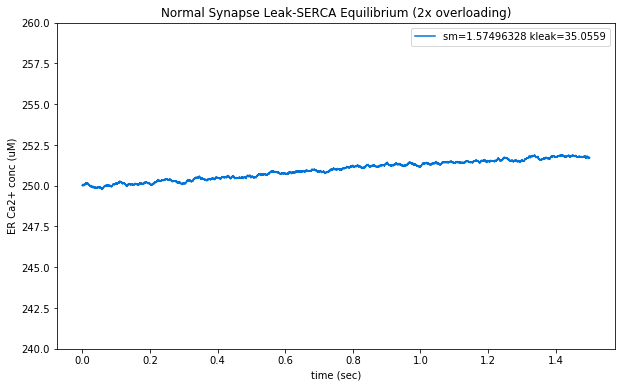

In [41]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2

#sm=70sm=0
sf=2
#ic=300

plt.figure(figsize=(10,6))
for i,(sm,k_leak) in enumerate(zip(serca_mult,k_leaks)):
    ydata=data1[sm].T[1]
    xdata=data1[sm].T[0]
    
    plt.plot(xdata,ydata,color=color[i%12],label='sm='+str(sm)+" kleak="+str(k_leak))
plt.legend()
plt.ylim((240,260))
plt.xlabel("time (sec)")
plt.ylabel("ER Ca2+ conc (uM)")
plt.title("Normal Synapse Leak-SERCA Equilibrium (2x overloading)")
plt.savefig('/home/kabir/Project/plots/brute6/final750.eps')

# Checking leak flux at various ldf

In [103]:
%run averaging1.ipynb
#checking refilling times for 500 sf=2
data_locs=[]
#data_type=['pmca&leak_ca_flux.dat']
data_type=['ca.dat','pmca&leak_ca_flux.dat']
columns=[[3],[3]]

for (ic,(sm,k_leak),ldf) in product(initial_conc,zip(serca_mult,k_leaks),leak_density_factor):
    #print(sm,ic,k_leak)
    loc="/data/kabir/output/ppf/"+outfolder+"/ldf"+str(ldf)+"/kleak"+str(k_leak)+"/"
    data_locs.append(loc)
    print(loc)

p=Pool(ncores-1)
data_list=p.starmap(averager,[(a,b,c) for (a,(b,c)) in product(data_locs,zip(data_type,columns))])
sm_len=len(serca_mult)
ic_len=len(initial_conc)

/data/kabir/output/ppf/brute12/ldf1/kleak255/
/data/kabir/output/ppf/brute12/ldf1/kleak356/
/data/kabir/output/ppf/brute12/ldf1/kleak416/
/data/kabir/output/ppf/brute12/ldf1/kleak458/
/data/kabir/output/ppf/brute12/ldf1/kleak491/
/data/kabir/output/ppf/brute12/ldf1/kleak518/
/data/kabir/output/ppf/brute12/ldf1/kleak540/
/data/kabir/output/ppf/brute12/ldf1/kleak560/
/data/kabir/output/ppf/brute12/ldf1/kleak577/


ValueError: min() arg is an empty sequence

In [9]:
#load data
data1={}

#ic=250
for (ic,(sm,k_leak),ldf) in product(initial_conc,zip(serca_mult,k_leaks),leak_density_factor):
    #data_file="/data/kabir/output/ppf/"+outfolder+"/ldf"+str(ldf)+"/kleak"+str(k_leak)+'/Average/pmca&leak_ca_flux.dat'
    data_file="/data/kabir/output/ppf/"+outfolder+"/Average/pmca&leak_ca_flux.dat"
    #print data_file
    data1[ldf]=np.loadtxt(data_file)
    #data1[ldf].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

[ 7.57856976e+01 -5.94013475e-02]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned


Text(0,0.5,'Flux Rate (Calcium ions/sec)')

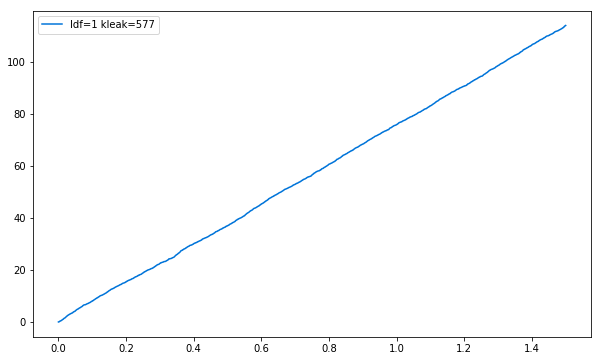

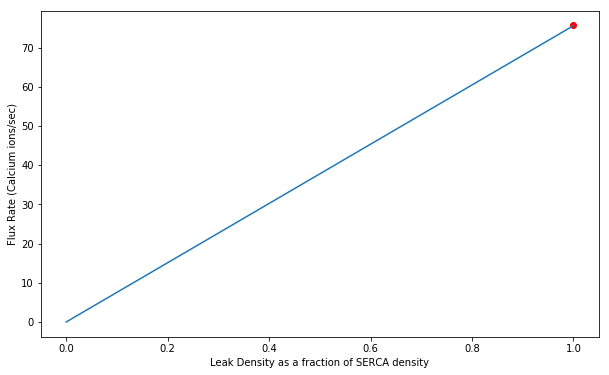

In [10]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2

#sm=70sm=0
sf=2
#ic=300
k_leak=577
plt.figure(figsize=(10,6))
flux_rate={}
for i,ldf in enumerate(leak_density_factor):
    ydata=data1[ldf].T[1]
    xdata=data1[ldf].T[0]
    plt.plot(xdata,ydata,color=color[i%12],label='ldf='+str(ldf)+" kleak="+str(k_leak))
    p=np.polyfit(xdata,ydata,1)
    flux_rate[ldf]=p[0]
    
plt.legend()
plt.figure(figsize=(10,6))
plt.plot(leak_density_factor,[flux_rate[ldf] for ldf in leak_density_factor],'ro')
np.polyfit(leak_density_factor,[flux_rate[ldf] for ldf in leak_density_factor],1)
print(p)
x=np.linspace(0,1,100)
plt.plot(x,p[0]*x+p[1])
plt.xlabel("Leak Density as a fraction of SERCA density")
plt.ylabel("Flux Rate (Calcium ions/sec)")
#plt.savefig('/home/kabir/Project/plots/brute6/ldf_leakrate.eps')
#plt.xlim((0,0.005))

# ER Ca plot

In [34]:
%run averaging1.ipynb
#checking refilling times for 500 sf=2
data_locs=[]
#data_type=['pmca&leak_ca_flux.dat']
data_type=['ca.dat','pmca&leak_ca_flux.dat']
columns=[[3],[3]]

for (ic,(sm,k_leak),ldf) in product(initial_conc,zip(serca_mult,k_leaks),leak_density_factor):
    #print(sm,ic,k_leak)
    loc="/data/kabir/output/ppf/"+outfolder+"/ldf"+str(ldf)+"/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/kleak"+str(k_leak)+"/"
    data_locs.append(loc)
    #print(loc)
p=Pool(ncores-1)
g=[(a,b,c) for (a,(b,c)) in product(data_locs,zip(data_type,columns))]
data_list=p.starmap(averager,g)
sm_len=len(serca_mult)
ic_len=len(initial_conc)

ValueError: min() arg is an empty sequence

In [12]:
#load data 500
data1={}

#ic=250
for (ic,(sm,k_leak),ldf) in product(initial_conc,zip(serca_mult,k_leaks),leak_density_factor):
    data_file="/data/kabir/output/ppf/"+outfolder+"/ldf"+str(ldf)+"/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/kleak"+str(k_leak)+'/Average/ca.dat'
    #print data_file
    data1[sm]=np.loadtxt(data_file)
    data1[sm].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

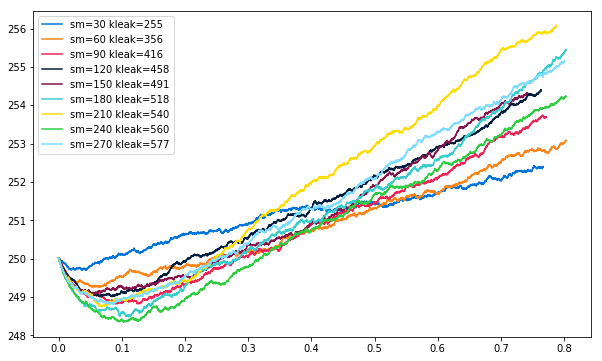

In [13]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2

#sm=70sm=0
sf=2
#ic=300

plt.figure(figsize=(10,6))
for i,(sm,k_leak) in enumerate(zip(serca_mult,k_leaks)):
    ydata=data1[sm].T[1]
    xdata=data1[sm].T[0]
    
    plt.plot(xdata,ydata,color=color[i%12],label='sm='+str(sm)+" kleak="+str(k_leak))
plt.legend()
#plt.xlim((0,0.005))

In [138]:
%run averaging1.ipynb
#checking refilling times for 500 sf=2
data_locs=[]
#data_type=['pmca&leak_ca_flux.dat']
data_type=['ca.dat']
columns=[[3]]

for (ic,(sm,k_leak)) in product(initial_conc,zip(serca_mult,k_leaks)):
    #print(sm,ic,k_leak)
    loc="/data/kabir/output/ppf/"+outfolder+"/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/kleak"+str(k_leak)+"/"
    data_locs.append(loc)
    print(loc)
p=Pool(ncores-1)
g=[(a,b,c) for (a,(b,c)) in product(data_locs,zip(data_type,columns))]
data_list=p.starmap(averager,g)
sm_len=len(serca_mult)
ic_len=len(initial_conc)

/data/kabir/output/ppf/brute12/sm30/2/250/kleak255/
/data/kabir/output/ppf/brute12/sm60/2/250/kleak356/
/data/kabir/output/ppf/brute12/sm90/2/250/kleak416/
/data/kabir/output/ppf/brute12/sm120/2/250/kleak458/
/data/kabir/output/ppf/brute12/sm150/2/250/kleak491/
/data/kabir/output/ppf/brute12/sm180/2/250/kleak518/
/data/kabir/output/ppf/brute12/sm210/2/250/kleak540/
/data/kabir/output/ppf/brute12/sm240/2/250/kleak560/
/data/kabir/output/ppf/brute12/sm270/2/250/kleak577/


ValueError: min() arg is an empty sequence

In [155]:
#load data 500
data1={}

#ic=250
for (ic,(sm,k_leak)) in product(initial_conc,zip(serca_mult,k_leaks)):
    data_file='/data/kabir/output/ppf/'+outfolder+'/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/kleak'+str(k_leak)+'/Average/ca.dat'
    #print data_file
    data1[sm]=np.loadtxt(data_file)
    data1[sm].T[3]*=1e15/N_avo/vol_er*1e6 #micromolar

OSError: /data/kabir/output/ppf/brute12/sm30/2/250/kleak255/Average/ca.dat not found.

In [157]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2

#sm=70sm=0
sf=2
#ic=300

plt.figure(figsize=(10,6))
for i,(sm,k_leak) in enumerate(zip(serca_mult,k_leaks)):
    ydata=data1[sm].T[3]
    xdata=data1[sm].T[0]
    
    plt.plot(xdata,ydata,color=color[i%12],label='sm='+str(sm)+" kleak="+str(k_leak))
plt.legend()
#plt.xlim((0,0.005))

IndexError: index 3 is out of bounds for axis 0 with size 2

In [10]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2
ic=250
#sm=70
#ic=300
slope_sm={'slope':[],'sm':[]}
plt.figure(figsize=(10,6))
for i,(sm,k_leak) in enumerate(zip(serca_mult,k_leaks)):
    ydata=(2*(data_sm[sm].T[2]-data_sm[sm].T[1])-data_leak[k_leak].T[1]-bnd_cal[sm])*(1e15/N_avo/vol_er*1e6)+250#data_sm[sm].T[2]-data_sm[sm].T[1]-data_leak[k_leak].T[1]+
    #ydata=-data_leak[k_leak].T[1]*(1e15/N_avo/vol_er*1e6)+250
    xdata=data_sm[sm].T[0]
    #ydata = gaussian_filter1d(ydata, sigma=300)
    plt.plot(xdata,ydata,color=color[i],lw=1,alpha=1,label='sm='+str(sm))

    p=np.polyfit(xdata[-5000:],ydata[-5000:],1)
    x=np.linspace(0,1.5,100)
    #plt.plot(x,np.polyval(p,x),color=color[i])
    dp=np.polyder(p)
    slope_sm['slope'].append(np.polyval(dp,xdata[-1]))
    slope_sm['sm'].append(sm)
    
plt.legend()

plt.figure(figsize=(10,6))
plt.plot(np.log(slope_sm['sm']),slope_sm['slope'],'ro',label="serca influx")
plt.ylabel("Ca2+ Flux (molecule/sec) at 250uM")
plt.xlabel("log(sm)")
plt.title("sm and slope at 250uM")
p=np.polyfit(np.log(slope_sm['sm']),slope_sm['slope'],1)
x=np.linspace(1,6,100)
plt.plot(x,np.polyval(p,x),label='Line='+str(p))

plt.plot(np.log(slope_sm['sm']),slope_kleak['slope'],'bo',label="leak outflux")

plt.legend()
#plt.savefig('/home/kabir/Project/plots/brute6/log_sm_slope_clamp.eps')#"""

NameError: name 'data_sm' is not defined

In [60]:
40/1.5*N_avo*vol_er*1e-15*1e-6  #(umol/l) * (um^3*molecules/mol) *(10^-15lit/um3)

626.3026536000002

# This is for leak parameter slope at 250uM

In [6]:
%run averaging1.ipynb
#checking refilling times for 500 sf=2

data_locs=[]

data_type=['pmca&leak_ca_flux.dat']
columns=[[3]]


for (ic,(sm,k_leak)) in product(initial_conc,zip(serca_mult,k_leaks)):
    loc="/data/kabir/output/ppf/"+outfolder+"/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/kleak"+str(k_leak)+"/"
    data_locs.append(loc)


p=Pool(ncores)
data_list=p.starmap(averager,product(data_locs,data_type,columns))
sm_len=len(serca_mult)
ic_len=len(initial_conc)

ValueError: min() arg is an empty sequence

In [6]:
#load data 500
data_leak={}

for (ic,(sm,k_leak),ldf) in product(initial_conc,zip(serca_mult,k_leaks),leak_density_factor):
    #data_file='/data/kabir/output/ppf/'+outfolder+'/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/kleak'+str(k_leak)+'/Average/pmca&leak_ca_flux.dat'
    data_file="/data/kabir/output/ppf/"+outfolder+"/ldf"+str(ldf)+"/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/kleak"+str(k_leak)+'/Average/pmca&leak_ca_flux.dat'
    #print data_file
    data_leak[k_leak]=np.loadtxt(data_file)
    

[2.1675959461586873, 6.214988757731395]


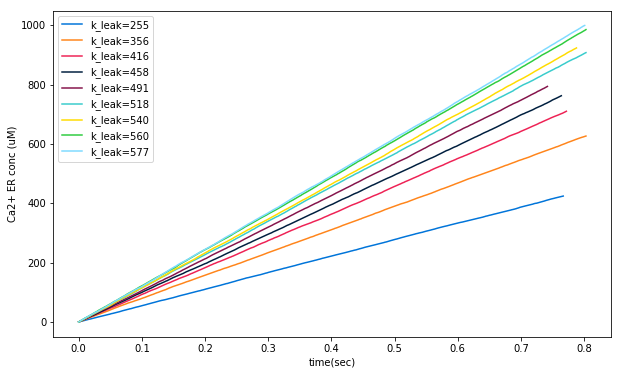

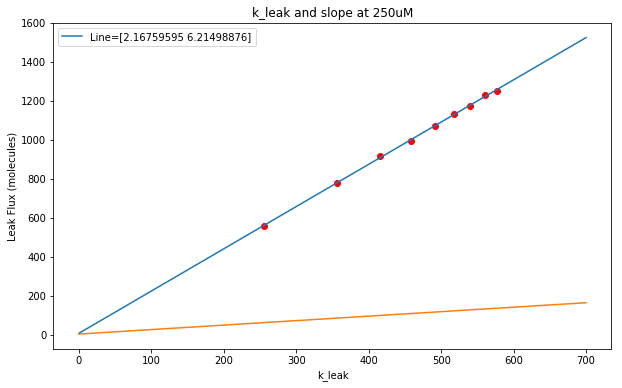

In [12]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2
ic=250
#sm=70
#ic=300
slope_kleak={'slope':[],'k_leak':[]}
plt.figure(figsize=(10,6))
for i,k_leak in enumerate(k_leaks):
    ydata=data_leak[k_leak].T[1]
    xdata=data_leak[k_leak].T[0]
    #dp=np.polyder(p)
    plt.plot(xdata,ydata,color=color[i%12],label='k_leak='+str(k_leak))
        

    
    p=np.polyfit(xdata,ydata,1)
    x=np.linspace(0,0.08,100)
    slope_kleak['slope'].append(p[0])
    slope_kleak['k_leak'].append(k_leak)

#for key in more_slope_conc.keys():
    #more_slope_conc[key]=np.array(more_slope_conc[key])
plt.xlabel("time(sec)")
plt.ylabel("Ca2+ ER conc (uM)")
plt.legend()
#plt.ylim((0,275))    
#plt.xlim((0,0.005))
#plt.savefig('/home/kabir/Project/plots/brute6/leak_rate.eps')""""""
#plt.savefig('/home/kabir/Project/midsemreport_spring2019/new_sm.eps')
plt.figure(figsize=(10,6))
plt.plot(slope_kleak['k_leak'],slope_kleak['slope'],'ro')
plt.ylabel("Leak Flux (molecules)")
plt.xlabel("k_leak")
plt.title("k_leak and slope at 250uM")
p=np.polyfit(slope_kleak['k_leak'],slope_kleak['slope'],1)
x=np.linspace(0,700,100)
plt.plot(x,np.polyval(p,x),label="Line="+str(p))
plt.plot(x,np.polyval([0.22979017, 2.47530845],x))
plt.legend()
print(list(p))
#plt.xlim((0,70000))
#plt.ylim((-800,0))
#plt.savefig('/home/kabir/Project/plots/brute6/k_leak_slope_clamp.eps')


In [16]:
#from S Bandara et al 2013
J=0.014*250 #uM/s
J/=1e15/N_avo/vol_er*1e6
print("Ca Flux in ions/sec = ",J)

p=[2.1675959461586873, 6.214988757731395]
kleak=(J-p[1])/p[0]
print("Predicted kleak = ",kleak)

Ca Flux in ions/sec =  82.20222328500002
Predicted kleak =  35.05599586580223


# Below is for sm parameter and slope at 250uM

In [31]:
%run averaging1.ipynb
#checking refilling times for 500 sf=2

data_locs=[]
data_type=['serca_ca_flux.dat']
columns=[[1,2]]

for (ic,(sm,k_leak)) in product(initial_conc,zip(serca_mult,k_leaks)):
    loc="/data/kabir/output/ppf/"+outfolder+"/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/kleak"+str(k_leak)+"/"
    data_locs.append(loc)

p=Pool(ncores-1)
data_list=p.starmap(averager,product(data_locs,data_type,columns))
sm_len=len(serca_mult)
ic_len=len(initial_conc)#"""

In [54]:
%run averaging1.ipynb
#average bound Ca on ER side

data_locs=[]
data_type=['serca_mol.dat']
columns=[[4,5]]

for (ic,(sm,k_leak)) in product(initial_conc,zip(serca_mult,k_leaks)):
    loc="/data/kabir/output/ppf/"+outfolder+"/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/kleak"+str(k_leak)+"/"
    data_locs.append(loc)

p=Pool(ncores)
data_list=p.starmap(averager,product(data_locs,data_type,columns))
sm_len=len(serca_mult)
ic_len=len(initial_conc)#"""

In [86]:
#load data 500
data_sm={}

for (ic,(sm,k_leak)) in product(initial_conc,zip(serca_mult,k_leaks)):
    data_file='/data/kabir/output/ppf/'+outfolder+'/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/kleak'+str(k_leak)+'/s_00001/dat/serca_ca_flux.dat'
    #print data_file
    data_sm[sm]=np.loadtxt(data_file)
    #data2[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

In [87]:
#load data 500
data_bound={}
bnd_cal={}
for (ic,(sm,k_leak)) in product(initial_conc,zip(serca_mult,k_leaks)):
    data_file='/data/kabir/output/ppf/'+outfolder+'/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/kleak'+str(k_leak)+'/s_00001/dat/serca_mol.dat'
    #print data_file
    data_bound[sm]=np.loadtxt(data_file)
    bnd_cal[sm]=data_bound[sm].T[4]*2+data_bound[sm].T[5]
    bnd_cal[sm]=bnd_cal[sm]-bnd_cal[sm][0]


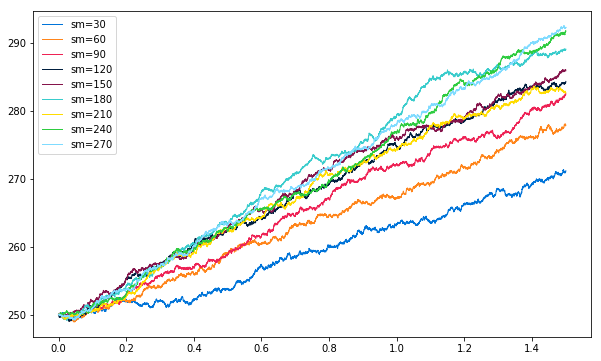

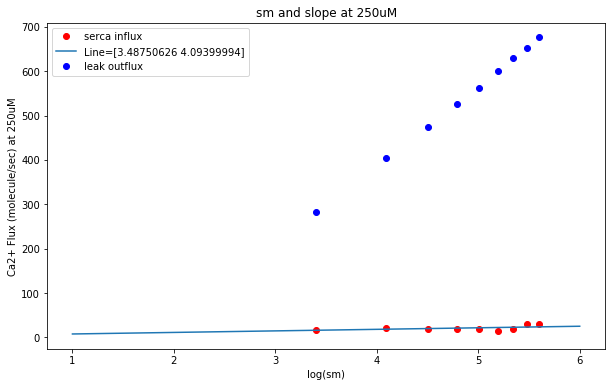

In [89]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2
ic=250
#sm=70
#ic=300
slope_sm={'slope':[],'sm':[]}
plt.figure(figsize=(10,6))
for i,(sm,k_leak) in enumerate(zip(serca_mult,k_leaks)):
    ydata=(2*(data_sm[sm].T[2]-data_sm[sm].T[1])-data_leak[k_leak].T[1]-bnd_cal[sm])*(1e15/N_avo/vol_er*1e6)+250#data_sm[sm].T[2]-data_sm[sm].T[1]-data_leak[k_leak].T[1]+
    xdata=data_sm[sm].T[0]
    #ydata = gaussian_filter1d(ydata, sigma=300)
    plt.plot(xdata,ydata,color=color[i],lw=1,alpha=1,label='sm='+str(sm))

    p=np.polyfit(xdata[-5000:],ydata[-5000:],1)
    x=np.linspace(0,1.5,100)
    #plt.plot(x,np.polyval(p,x),color=color[i])
    dp=np.polyder(p)
    slope_sm['slope'].append(np.polyval(dp,xdata[-1]))
    slope_sm['sm'].append(sm)
    
plt.legend()

plt.figure(figsize=(10,6))
plt.plot(np.log(slope_sm['sm']),slope_sm['slope'],'ro',label="serca influx")
plt.ylabel("Ca2+ Flux (molecule/sec) at 250uM")
plt.xlabel("log(sm)")
plt.title("sm and slope at 250uM")
p=np.polyfit(np.log(slope_sm['sm']),slope_sm['slope'],1)
x=np.linspace(1,6,100)
plt.plot(x,np.polyval(p,x),label='Line='+str(p))

plt.plot(np.log(slope_sm['sm']),slope_kleak['slope'],'bo',label="leak outflux")

plt.legend()
#plt.savefig('/home/kabir/Project/plots/brute6/log_sm_slope_clamp.eps')#"""

In [26]:
#load data 500 comparing with sm from previous experiment
ic=250
data3={}
serca_mult=np.arange(30,300,30)
initial_conc=[250]
k_leaks=[0]
for sm in serca_mult:
    data3[sm]={}
    for ic in initial_conc:
        for k_leak in k_leaks:
            data_file='/data/kabir/output/ppf/brute11/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/kleak'+str(k_leak)+'/Average/serca_ca_flux.dat'
            #print data_file
            data3[sm][ic]=np.loadtxt(data_file)
            #data3[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

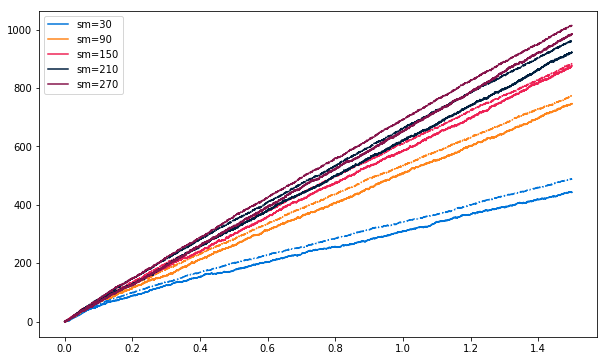

In [50]:
#plot the difference in serca flux when leak is also present -- with leaks

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2
ic=250
#sm=70
#ic=300
slope_sm={'slope':[],'sm':[]}
plt.figure(figsize=(10,6))
for i,sm in enumerate(serca_mult[0::2]):
    ydata=data3[sm][ic].T[2]-data3[sm][ic].T[1]
    xdata=data3[sm][ic].T[0]
    plt.plot(xdata,ydata,color=color[i],label='sm='+str(sm))
    ydata=data2[sm].T[2]-data2[sm].T[1]
    xdata=data2[sm].T[0]
    plt.plot(xdata,ydata,color=color[i],ls='-.')
    
#plt.ylim((600,1000))
#plt.xlim((1.2,1.5))
plt.legend()

In [295]:
#average,full refilling
initial_conc=[0]

serca_mult=[70,100,150]
serca_f=[2]
sf=serca_f[0]

#serca_mult=[1]#[3,6,9,12,15]#[1]
#serca_f=[2,2.2,2.4,2.6,2.8,2.9,3,3.1,3.2,3.4,3.6,3.8,4]

data_locs=[]
for sm in serca_mult:
    for ic in initial_conc:
        #averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        data_locs.append("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
p=Pool(7)
data_list=p.map(averager,data_locs)
sm_len=len(serca_mult)
ic_len=len(initial_conc)

In [296]:
#load data, full refilling
data={}
initial_conc=[0]

serca_mult=[70,100,150]
serca_f=[2]
sf=serca_f[0]
seed={70:8,100:4,150:2}
for sm in serca_mult:
    data[sm]={}
    for ic in initial_conc:
        data_file='/data/kabir/output/ppf/brute9/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/s_0000'+str(seed[sm])+'/dat/ca.dat'
        #print data_file
        data[sm][ic]=np.loadtxt(data_file)
        data[sm][ic].T[3]*=1e15/N_avo/vol_er*1e6 #micromolar

In [297]:
def exp_fit(x,c,tau):
    A=500
    return A*(1-np.exp(-(x-c)/tau))

In [298]:
def eval_slope_conc(t,xdata,ydata,range):
    tstep=xdata[1]-xdata[0]
    delta_t=range
    lower,upper=int(max(0,(t-delta_t)/tstep)),int(min(len(xdata),(t+delta_t)/tstep))
    a, b, r_value, p_value, std_err= stats.linregress(xdata[lower:upper],ydata[lower:upper])
    conc=a*t+b

    #print('conc=',conc,'tau=',tau,'error=',std_err)
    return a,conc

a= 0.3842133105762622 
b= -65.432415126828


NameError: name 'more_slope_conc' is not defined

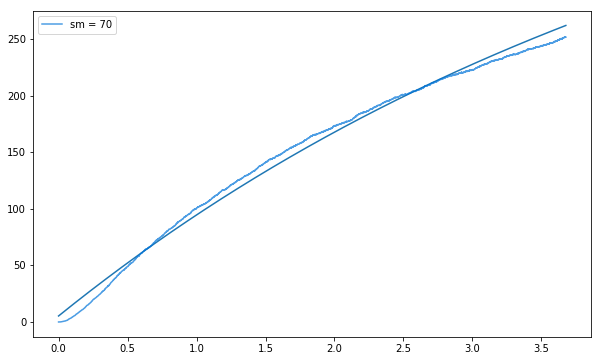

In [299]:
color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

ic=0
plt.figure(figsize=(10,6))
for i,sm in enumerate([70]):
    ydata=data[sm][ic].T[3]
    xdata=data[sm][ic].T[0]
    popt,pcov=curve_fit(exp_fit,xdata,ydata,p0=[0,5])
    plt.plot(xdata,exp_fit(xdata,*popt))
    plt.plot(xdata,ydata,color=color[i%12],label='sm = '+str(sm), alpha=0.7)
plt.legend()

plt.figure(figsize=(10,6))
for sm in [70]:
    slope_conc_data={'slope':[],'conc':[]}
    ydata=data[sm][ic].T[3]
    xdata=data[sm][ic].T[0]
    times=[1,1.5,2,2.5]
    for t in times: 
        slope,conc=eval_slope_conc(t,xdata,ydata,1)
        slope_conc_data['slope'].append(slope)
        slope_conc_data['conc'].append(conc)
    for key in slope_conc_data.keys():
        slope_conc_data[key]=np.array(slope_conc_data[key])
    xdata,ydata=500-slope_conc_data['conc'],slope_conc_data['slope']
    #plt.plot(xdata,ydata,'ro')
    a, b, r_value, p_value, std_err= stats.linregress(xdata,ydata)
    print('a=',a,'\nb=',b)
xdata=500-np.concatenate((slope_conc_data['conc'],more_slope_conc['conc']))
ydata=np.concatenate((slope_conc_data['slope'],more_slope_conc['slope']))
plt.plot(xdata,ydata,'ro',label="Data for sm=70")

def poly(x,A,B,C,D):
    return A*x**3+B*x**2+C*x+D
    #return x**A+B

popt,pcov=curve_fit(poly,xdata,ydata)
x=np.linspace(0,500,100)
y=spline(xdata, ydata, x, order=3, kind='smoothest')
plt.plot(x,poly(x,*popt),label="Cubic polynomial: [A B C D]="+str(popt))
print(popt)
#plt.xlim(())
plt.title("Slope vs 500-C for sm=70, sf=2")
plt.legend()
plt.xlabel("A-conc")
plt.ylabel("dC/dt")
plt.savefig('/home/kabir/Project/plots/brute6/slope_conc_sm70.eps')




In [51]:
def max_file_len(data_loc):
    seed_folders=os.listdir(data_loc)
    print(seed_folders)
    if "Average" in seed_folders:
        seed_folders.remove("Average")
    print(seed_folders)
    for s in seed_folders:
        file_name=os.path.join(data_loc,os.path.join(s+'/dat/ca.dat'))
        print(s,file_len(file_name))

In [47]:
def file_len(fname):
    i=-1
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [40]:
max_file_len("/data/kabir/output/ppf/brute11/sm240/2/250/0/")

[]


In [35]:
a= 0.3901029977136642 
b= -67.62046808120242

serca_conc_tot = 15e-6
serca_number_presynaptic=serca_conc_tot*vol_cyt/(1e15/6.02205e23)
leak_number=serca_number_presynaptic/10

ER_conc_rate=a*250+b #in micromolar per sec
serca_flux=ER_conc_rate*1e-6*vol_er*1e-18*1e3*N_avo#moles per sec *N_avo
k_leak=serca_flux/leak_number/250e-6
print("SERCA influx =",serca_flux,"Ca2+ ions per sec")
print("Leak number =",leak_number)
print("k_leak =",k_leak)

SERCA influx = 702.3658899155432 Ca2+ ions per sec
Leak number = 868.0785075
k_leak = 3236.4164478086363


In [33]:
serca_conc_tot = 15e-6
presynaptic_vol=(4*0.5*0.5-vol_er)
serca_number_presynaptic=serca_conc_tot*presynaptic_vol/(1e15/6.02205e23)
leak_number=serca_number_presynaptic/10
presynaptic_ER_leak_conc=leak_number/(vol_er*1e-15)/6.02205e23 #molarity
ER_leak_density_presynaptic = leak_number/area_er



868.0785075


In [52]:
max_file_len("/data/kabir/output/ppf/brute11/sm240/2/250/kleak2784/")

['Average']
[]


In [ ]:
def slope_from_conc(conc,xdata,ydata,polorder):
    p=np.polyfit(xdata,ydata,polorder)
    #x=np.linspace(0,1.5,100)
    #plt.plot(x,np.polyval(p,x),color=color[i])
    dp=np.polyder(p)
    p[-1]=p[-1]-conc
    t=np.roots(p)
    slope=np.polyval(dp,t[2])
    #print("Slope = ",slope," Conc = ",conc)
    slope_sm['slope'].append(slope)
    slope_sm['sm'].append(sm)
    return 

In [176]:
p=[ 8.56400156e-07, -1.07825697e-04, 1.28255652e-01, -4.63507474e-01]
np.polyval(p,250)

38.242551901

In [195]:
x=np.array([1,2,3,4])
conc=2.2
arg=np.argmin(abs(x-conc)
print(arg)

1


In [262]:
0.62*1e5

62000.0

In [263]:
np.arange(60000,70000,1000)

array([60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000,
       69000])

In [229]:
def f(b,a):
    return np.sum(np.array(a))+b
p=Pool(7)
p.starmap(f,product([1,2],[[2,3]]))

[6, 7]

In [4]:
As=168.11291085
Bs=-279.06388692
Al=0.22979017
Bl=2.47530845
A_new=As/Al
B_new=(Bs-Bl)/Al
print("A/A'=",str(A_new))
print("(B-B')/A'=",str(B_new))

A/A'= 731.5931349456768
(B-B')/A'= -1225.2012145254082


In [5]:
sm=np.arange(30,300,30)
kleak=A_new*np.log(sm)+B_new
print(kleak)

[1263.09144049 1770.1931593  2066.82864885 2277.2948781  2440.54516835
 2573.93036765 2686.70594676 2784.39659691 2870.56585721]


In [7]:
round(0.9)

1